In [1]:
import os
import random
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [2]:
def read_pgm(pgmf):
    header = pgmf.readline()
    assert header[:2] == b'P5'
    header = pgmf.readline()
    (width, height) = [int(i) for i in header.split()]
    header = pgmf.readline()
    depth = int(header.split()[0])
    assert depth <= 65535

    raster = []
    for i in range(height):
        for j in range(width):
            raster.append(float(ord(pgmf.read(1))))
    return raster

def read_data (data_path, dataset, data_labels):
    mylist = os.listdir(data_path)
    for j in mylist:
        mymylist = os.listdir(data_path + '\\' + j)
        for i in mymylist:
            f = open(data_path + '\\' + j + '\\' + i, 'rb')
            im = read_pgm(f)
            f.close()
            dataset.append(im)
            if i.find("sunglasses") == -1:
                data_labels.append(-1)
            else:
                data_labels.append(1)

                
data_path = r"D:\Takeen\University\6- Data Mining\Homework\HW2\faces_4"
first_dataset = []
first_data_labels = []
read_data(data_path, first_dataset, first_data_labels)

In [3]:
### part1

def devide_into_test_and_train (first_dataset, first_data_labels, test_perc):
    dataset = first_dataset[:]
    data_labels = first_data_labels[:]
    testset = []
    test_labels = []
    
    l = len(dataset)
    test_size = int(test_perc * l)

    for i in range(test_size):
        r = random.randint(0, l-1)
        testset.append(dataset.pop(r))
        test_labels.append(data_labels.pop(r))
        l -= 1

    #print(f'training set --> 1: {data_labels.count(1)/l} / -1: {data_labels.count(-1)/l}')
    #print(f'test set --> 1: {test_labels.count(1)/test_size} / -1: {test_labels.count(-1)/test_size}')
    
    return dataset, data_labels, testset, test_labels
    
test_perc = 0.3
dataset, data_labels, testset, test_labels = devide_into_test_and_train(first_dataset, first_data_labels, test_perc)

In [4]:
### part2

def build_classifier (dataset, data_labels, hidden_layers, learning_rate = None):
    if learning_rate == None:
        clf = MLPClassifier(solver='sgd', hidden_layer_sizes=hidden_layers, max_iter=750)
    else:
        clf = MLPClassifier(solver='sgd', hidden_layer_sizes=hidden_layers, max_iter=750, learning_rate_init=learning_rate)
    clf.fit(dataset, data_labels)
    return clf

classifier = build_classifier(dataset, data_labels, (50, 50, 50))

In [5]:
### part3

def report_error (clf, dataset, data_labels, testset, test_labels):
    # TRAINING ERROR
    result = list(clf.predict(dataset))
    count1 = 0
    l1 = len(dataset)
    for i in range(l1):
        if data_labels[i] == result[i]:
            count1 += 1

    # TEST ERROR
    result = list(clf.predict(testset))
    count2 = 0
    l2 = len(testset)
    for i in range(l2):
        if test_labels[i] == result[i]:
            count2 += 1
    
    return 1-count1/l1, 1-count2/l2

tr_err, test_err = report_error(classifier, dataset, data_labels, testset, test_labels)
            
print("training error rate = \t", tr_err)
print("test error rate = \t", test_err)

training error rate = 	 0.011441647597253968
test error rate = 	 0.15508021390374327


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


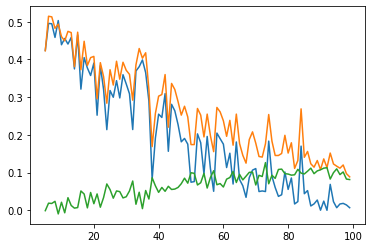

In [15]:
c1 = 5
c2 = 100

init_l = [i for i in range(c1, c2)]
tr_err_l = []
test_err_l = []

x = 10
for i in range(c1, c2):
    print(i)
    tr_err_list = [0 for i in range(x)]
    test_err_list = [0 for i in range(x)]
    for j in range(x):
        test_perc = 0.3
        dataset, data_labels, testset, test_labels = devide_into_test_and_train(first_dataset, first_data_labels, test_perc)
        classifier = build_classifier(dataset, data_labels, (i, i, i))
        tr_err_list[j], test_err_list[j] = report_error(classifier, dataset, data_labels, testset, test_labels)
    
    tr_err = sum(tr_err_list)/10
    test_err = sum(test_err_list)/10
    
    tr_err_l.append(tr_err)
    test_err_l.append(test_err)

diff = []
for i in range(len(tr_err_l)):
    diff.append(test_err_l[i] - tr_err_l[i])

plt.plot(init_l, tr_err_l, init_l, test_err_l, init_l, diff)

In [6]:
from math import sqrt

def validate (node_in_each_layer):
    iter_num = 10
    init_learning_rate = 0.01
    init_l = [i for i in range(iter_num)]
    tr_err_l = []
    test_err_l = []
    iter_num_l = []

    x = 15
    y = (node_in_each_layer, node_in_each_layer, node_in_each_layer)
    test_perc = 0.3
    a = init_learning_rate

    for i in range(iter_num):
        print(a)
        tr_err_list = [0 for i in range(x)]
        test_err_list = [0 for i in range(x)]
        iteration = [0 for i in range(x)]
        for j in range(x):
            dataset, data_labels, testset, test_labels = devide_into_test_and_train(first_dataset, first_data_labels, test_perc)
            classifier = build_classifier(dataset, data_labels, y, learning_rate = a)
            iteration[j] = classifier.n_iter_
            tr_err_list[j], test_err_list[j] = report_error(classifier, dataset, data_labels, testset, test_labels)

        tr_err_l.append(sum(tr_err_list)/x)
        test_err_l.append(sum(test_err_list)/x)
        iter_num_l.append(sum(iteration)/x)
        a = a / sqrt(sqrt(10))

    diff = []
    for i in range(len(tr_err_l)):
        diff.append(test_err_l[i] - tr_err_l[i])

    figure, axis = plt.subplots(1, 2)
    figure.set_size_inches(12, 5)
    axis[0].plot(init_l, tr_err_l, init_l, test_err_l, init_l, diff)
    axis[1].plot(init_l, iter_num_l)
    plt.show()

0.01
0.005623413251903491
0.0031622776601683794
0.001778279410038923
0.001
0.0005623413251903491
0.00031622776601683794
0.0001778279410038923
0.00010000000000000002
5.623413251903492e-05


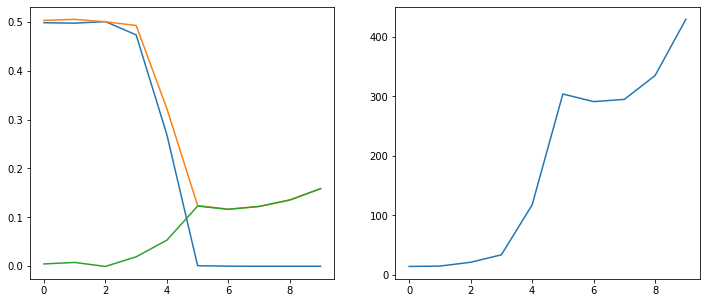

In [7]:
validate(40)

0.01
0.005623413251903491
0.0031622776601683794
0.001778279410038923
0.001
0.0005623413251903491
0.00031622776601683794
0.0001778279410038923
0.00010000000000000002
5.623413251903492e-05


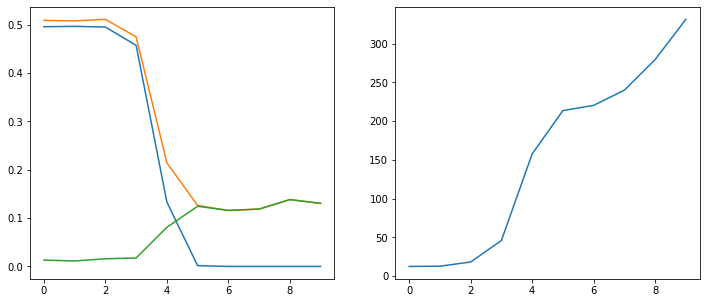

In [8]:
validate(60)

0.01
0.005623413251903491
0.0031622776601683794
0.001778279410038923
0.001
0.0005623413251903491
0.00031622776601683794
0.0001778279410038923
0.00010000000000000002
5.623413251903492e-05


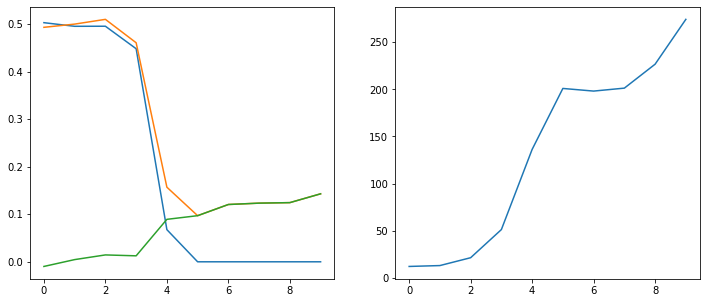

In [9]:
validate(80)

0.01
0.005623413251903491
0.0031622776601683794
0.001778279410038923
0.001
0.0005623413251903491
0.00031622776601683794
0.0001778279410038923
0.00010000000000000002
5.623413251903492e-05


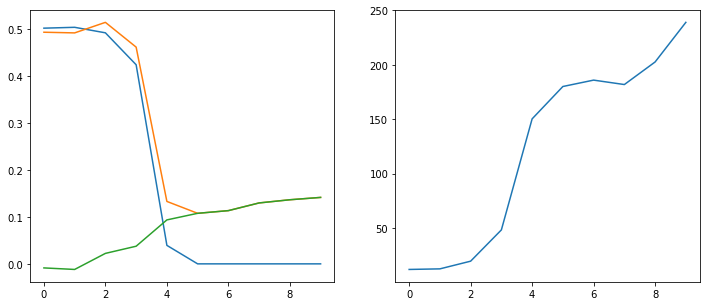

In [10]:
validate(100)

0.01
0.005623413251903491
0.0031622776601683794
0.001778279410038923
0.001
0.0005623413251903491
0.00031622776601683794
0.0001778279410038923
0.00010000000000000002
5.623413251903492e-05


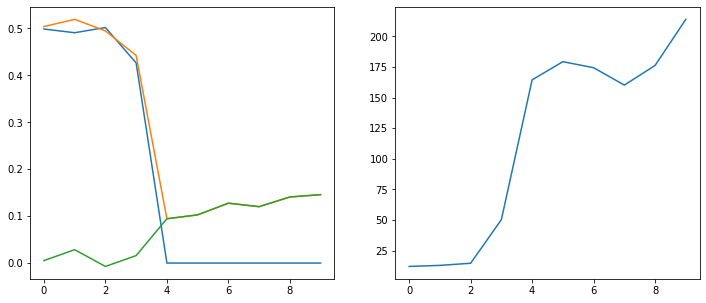

In [11]:
validate(120)

0.01
0.005623413251903491
0.0031622776601683794
0.001778279410038923
0.001
0.0005623413251903491
0.00031622776601683794
0.0001778279410038923
0.00010000000000000002
5.623413251903492e-05


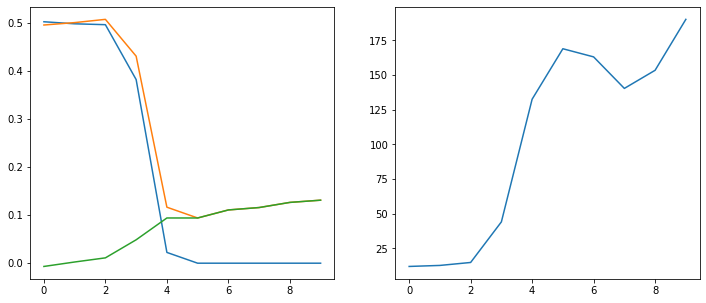

In [12]:
validate(140)